In [1]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import glob
import yaml
import torchvision

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # for cuda
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
set_seed(0)

In [4]:
def extract_files():
    import google.colab
    import zipfile

    google.colab.drive.mount('/content/drive')
    PROJECT_DIR = "/content/drive/MyDrive/thesis/data/"

    zip_ref = zipfile.ZipFile(PROJECT_DIR + "fiveK.zip", 'r')
    zip_ref.extractall(".")
    zip_ref.close()

In [5]:
if 'google.colab' in str(get_ipython()):
  extract_files()
  config_path = "/content/drive/MyDrive/thesis/config.yaml"
else:
  config_path = "../../config.yaml"

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [7]:
# List of class directories
class_directories = ['expA', 'expB', 'expC', 'expD', 'expE']
# raw data directory
raw_dir = "raw"

In [8]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, raw_data_dir, filename, transform=None):
        super().__init__()
        self.filename = filename
        self.transform = transform

        self.classname = self._extract_class_name(data_dir)
        self.encode = {k: i for i, k in enumerate(class_directories)}


        # Read the train.txt file and store the image paths
        with open(self.filename) as f:
            img_paths= []
            raw_img_paths = []
            for line in f:
                line = line.strip()
                img_paths.append(os.path.join(data_dir, line))
                raw_img_paths.append(os.path.join(raw_data_dir, line))

            self.image_paths = img_paths
            self.raw_image_paths = raw_img_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        raw_image_path = self.raw_image_paths[index]
        image = Image.open(image_path)
        raw_image = Image.open(raw_image_path)
        image = np.dstack((np.array(image), np.array(raw_image)))
        label = self.encode[self.classname]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def _extract_class_name(self, root_dir):
        # Extract the class name from the root directory
        class_name = os.path.basename(root_dir)
        return class_name

In [9]:
try:
    # Load configuration
    with open(config_path, 'r') as config_file:
        config = yaml.safe_load(config_file)
except:
    raise FileNotFoundError(f"Config file not found at path: {config_path}")

In [10]:
try:
    # Load configuration
    with open(config_path, 'r') as config_file:
        config = yaml.safe_load(config_file)
except:
    raise FileNotFoundError(f"Config file not found at path: {config_path}")

In [11]:
data_folder = config['paths']['data']
train_file = config['paths']['train']
test_file = config['paths']['test']

In [12]:
def read_dataset(data_folder, txt_file, trasform=None):
    # Create separate datasets for each class
    datasets = []

    for class_dir in class_directories:
        class_train_dataset = CustomDataset(
            data_dir=os.path.join(data_folder, class_dir),
            raw_data_dir=os.path.join(data_folder, raw_dir),
            filename=os.path.join(txt_file),
            transform=trasform
        )
        datasets.append(class_train_dataset)
    return datasets

In [42]:
training_tr = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(224, antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
        # transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
        # transforms.RandomEqualize(),    
        transforms.Normalize([0.485, 0.456, 0.406, 0.485, 0.456, 0.406], [0.229, 0.224, 0.225, 0.229, 0.224, 0.225])
    ])

test_tr = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406, 0.485, 0.456, 0.406], [0.229, 0.224, 0.225, 0.229, 0.224, 0.225])
    ])

In [43]:
# Combine datasets if needed (e.g., for training)
train_dataset = torch.utils.data.ConcatDataset(read_dataset(data_folder, train_file, training_tr))
test_dataset = torch.utils.data.ConcatDataset(read_dataset(data_folder, test_file, test_tr))

In [44]:
bs = 128

In [45]:
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs*2, shuffle=False)

In [46]:
train_features, train_labels = next(iter(train_dataloader))


TypeError: Only torch.uint8 image tensors are supported, but found torch.float32

In [ ]:
train_features.size()


torch.Size([128, 6, 224, 224])

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    org_img = inp[:, :, :3]
    raw_img = inp[:, :, 3:]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    org_img = std * org_img + mean
    raw_img = std * raw_img + mean
    org_img = np.clip(org_img, 0, 1)
    raw_img = np.clip(raw_img, 0, 1)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot original image on the first subplot
    axes[0].imshow(org_img)
    if title is not None:
        axes[0].set_title(title)
    axes[0].axis('off')

    # Plot raw image on the second subplot
    axes[1].imshow(raw_img)
    axes[1].set_title('Raw Image')
    axes[1].axis('off')

    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()

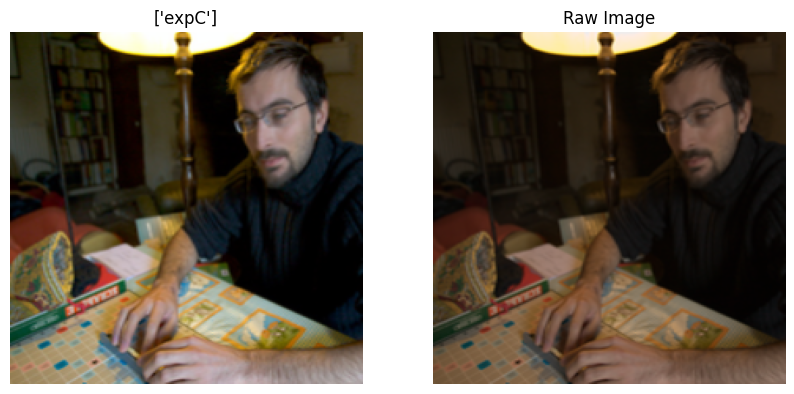

In [ ]:
# Get a batch of training data
inputs, labels = next(iter(train_dataloader))
out = inputs[:1].squeeze()

imshow(out, title=[class_directories[x] for x in labels[:1]])

In [ ]:
print(len(train_dataset))

20000


In [ ]:
base_checkpoint_path = config['paths']['checkpoints']
# Create the directory if it does not exist
if not os.path.exists(base_checkpoint_path):
    os.makedirs(base_checkpoint_path)


In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
def train_model(model, criterion, optimizer, scheduler, current_epoch, num_epochs=25):
    since = time.time()
    best_acc = 0.0
    model.train()
    for epoch in range(current_epoch, num_epochs):
            # formatted string to append epoch number to checkpoint filename
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        running_loss = 0.0
        running_corrects = 0
        # Iterate over data.
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} LR: {get_lr(optimizer):.8f}')
        print()

        PATH = os.path.join(base_checkpoint_path, f'{os.path.basename(base_checkpoint_path)}_{epoch+1}.pth')
        # save checkpoint
        state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': epoch_loss,
            'scheduler': scheduler.state_dict(),
            'accuracy': epoch_acc
        }
        # save the best model parameters
        torch.save(state, PATH)
        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Acc: {best_acc:4f}')

In [ ]:
model_name = config['model']['name']
if not model_name.startswith('resnet'):
    raise ValueError("Model name must start with 'resnet'")

In [ ]:
if config['model']['type'] == 'FEATURE_EXTRACTOR':
    model = torchvision.models.__dict__[model_name](weights='IMAGENET1K_V1')
    # Freeze all layers except the fully connected layers
    for param in model.parameters():
        param.requires_grad = False
elif config['model']['type'] == 'FINE_TUNING':
    model = torchvision.models.__dict__[model_name](weights='IMAGENET1K_V1')
elif config['model']['type'] == 'TRAIN_FROM_SCRATCH':
    model = torchvision.models.__dict__[model_name](weights=None)
else:
    raise ValueError(f"Unknown model type: {config['model']['type']}")

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc =  nn.Linear(num_ftrs, config['model']['num_classes'])

# change the first convolution to accept 6 channels
model.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# move the model to GPU/CPU
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=config['model']['lr'], momentum=config['model']['momentum'])

milestones = [9, 18, 34, 50, 70]

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

In [ ]:
# load the last model saved if there is any
def load_latest_model(model, optimizer, scheduler, checkpoint_dir):
    # Check if the directory exists
    if not os.path.exists(base_checkpoint_path):
        print(f"No directory found: {checkpoint_dir}")
        return model, optimizer, scheduler, 0, None

    # Get a list of all checkpoint files in the directory
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, f'{os.path.basename(checkpoint_dir)}_*.pth'))
    print(checkpoint_files)
    # Check if any checkpoint files are present
    if not checkpoint_files:
        print(f"No checkpoints found in the directory: {checkpoint_dir}")
        return model, optimizer, scheduler, 0, None

    # Find the latest checkpoint file based on the epoch number in the filename
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)

    # Load the latest checkpoint
    checkpoint = torch.load(latest_checkpoint, map_location=torch.device(device))
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(checkpoint['accuracy'])

    print(f"Loaded model from checkpoint: {latest_checkpoint}")
    print(f"Resuming training from epoch {epoch}")

    return model, optimizer,scheduler, epoch, loss


In [ ]:
model, optimizer, scheduler, current_epoch, loss = load_latest_model(model, optimizer, scheduler, base_checkpoint_path)

[]
No checkpoints found in the directory: /content/drive/MyDrive/thesis/model/checkpoints/resetnet50_scratch_raw


In [ ]:
print(get_lr(optimizer))

0.01


In [ ]:
train_model(model, criterion, optimizer, scheduler,current_epoch, num_epochs=config['model']['num_epochs'])

Epoch 1/80
----------
Loss: 1.8919 Acc: 0.2657 LR: 0.01000000

Epoch 2/80
----------
Loss: 1.5031 Acc: 0.3679 LR: 0.01000000

Epoch 3/80
----------
Loss: 1.4509 Acc: 0.3945 LR: 0.01000000

Epoch 4/80
----------
Loss: 1.3949 Acc: 0.4219 LR: 0.01000000

Epoch 5/80
----------
Loss: 1.3628 Acc: 0.4372 LR: 0.01000000

Epoch 6/80
----------
Loss: 1.3333 Acc: 0.4529 LR: 0.01000000

Epoch 7/80
----------
Loss: 1.3111 Acc: 0.4652 LR: 0.01000000

Epoch 8/80
----------
Loss: 1.2853 Acc: 0.4760 LR: 0.01000000

Epoch 9/80
----------
Loss: 1.2677 Acc: 0.4873 LR: 0.00100000

Epoch 10/80
----------
Loss: 1.1954 Acc: 0.5176 LR: 0.00100000

Epoch 11/80
----------
Loss: 1.1725 Acc: 0.5273 LR: 0.00100000

Epoch 12/80
----------
Loss: 1.1624 Acc: 0.5331 LR: 0.00100000

Epoch 13/80
----------
Loss: 1.1516 Acc: 0.5361 LR: 0.00100000

Epoch 14/80
----------
Loss: 1.1457 Acc: 0.5417 LR: 0.00100000

Epoch 15/80
----------
Loss: 1.1413 Acc: 0.5433 LR: 0.00100000

Epoch 16/80
----------
Loss: 1.1359 Acc: 0.5439 L

In [ ]:
time.sleep(5)  # Sleep for 5 seconds to let the system cool down
from google.colab import runtime
runtime.unassign()